In [1]:
import mpramnist
from mpramnist.sharpdataset import SharpDataset

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
 
import boda

# Initiate some parameters

In [2]:
BATCH_SIZE = 512
NUM_WORKERS = 103
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
SharpDataset.ACTIVITY_COLUMNS

['k562_minp_rep1',
 'k562_minp_rep2',
 'k562_minp_avg',
 'k562_sv40p_rep1',
 'k562_sv40p_rep1',
 'k562_sv40p_avg',
 'hepg2_minp_rep1',
 'hepg2_minp_rep2',
 'hepg2_minp_avg',
 'hepg2_sv40p_rep1',
 'hepg2_sv40p_rep2',
 'hepg2_sv40p_avg']

In [4]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5),
])
test_transform = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 
])

# load the data
train_dataset = SharpDataset(split="train", transform=train_transform)# for needed folds
val_dataset = SharpDataset( split="val", transform=test_transform) # use "val" for default validation set
test_dataset = SharpDataset( split="test", transform=test_transform) # use "test" for default test set

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

# Some dataset Info

In [5]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset SharpDataset of size 457174 (MpraDaraset)
    Number of datapoints: 457174
    Default split folds: {}
    Used split fold: train
    Scalar features: {}
    Vector features: {}
    Cell types: []
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 145
    Sequence size: 1
    Number of samples: {}
    Description: SharprDataset is based on 
Dataset SharpDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Default split folds: {}
    Used split fold: val
    Scalar features: {}
    Vector features: {}
    Cell types: []
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 145
    Sequence size: 1
    Number of samples: {}
    Description: SharprDataset is based on 
Dataset SharpDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Default split folds: {}
    Used split fold: test
    Scalar features: {}
    Vector features: {}
    Cell types: []
    Сell type used: None

# Define LegNet

In [5]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

# MAlinois

In [6]:
class Malinois(nn.Module):
    def __init__(self, n_outputs = 12) -> None:
        super().__init__()

        self.model = boda.model.BassetBranched(
            input_len=600,
            n_outputs=n_outputs,
            n_linear_layers=1,
            linear_channels=1000,
            linear_dropout_p = 0.11625456877954289,
            n_branched_layers = 3,
            branched_channels = 140,
            branched_activation = "ReLU",
            branched_dropout_p = 0.5757068086404574,
            loss_criterion = "L1KLmixed",
            loss_args={'beta': 5.0},
        )
    
    def forward(self, x):
        # x is of shape (batch_size, seqlen, 4). pad with zeros to (batch_size, 600, 4)
        x = x.permute(0, 2, 1) # (batch_size, 4, 600)
        
        assert x.shape[1] <= 600, "sequence length must be less than or equal to 600 for Malinois"

        pad_size = 600 - x.shape[1]
        left_pad = pad_size // 2
        right_pad = pad_size - left_pad
        x = F.pad(x, (0, 0, left_pad, right_pad), mode='constant', value=0)
        
        x = x.permute(0, 2, 1)

        encoded = self.model.encode(x)
        decoded = self.model.decode(encoded)
        output  = self.model.classify(decoded)
        return output

# Define metrics and SeqModel

In [13]:
import pytorch_lightning as L
from torch.nn import functional as F

def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch, output_dim = 12, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=4,
                                 output_dim = 12,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[256, 128, 128, 128, 64, 64],
                                 pool_sizes=[2,2,2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        
        #self.model = Malinois()
        
        self.loss = nn.MSELoss() 
        self.lr = lr
        self.output = output_dim
        self.val_loss = []
        self.val_pears = [[] for i in range(output_dim)]
        
        self.last_batch = []
        self.last_y = []
        
        self.train_loss = []
        self.train_pears = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)

        corr = pearson_correlation(y_hat, y)
        self.train_pears.append(corr)
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        self.last_batch = y_hat
        self.last_y = y
        
        for i in range(y.shape[-1]):
            corr = pearson_correlation(y_hat[:,i], y[:,i])
            self.val_pears[i].append(corr)
        self.log(f"val_pearson", pearson_correlation(y_hat, y), on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        
        if len(self.train_loss) != 0:
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
            train_pears = torch.stack(self.train_pears, dim = 0).mean()
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        val_pears = []
        for i in range(self.output):
            if i%3 == 0:
                res_str += '\n{}: {:.5f} |'.format(f"val_p_{SharpDataset.ACTIVITY_COLUMNS[i]}", torch.tensor(self.val_pears[i]).mean())
            else:
                res_str += '{}: {:.5f} |'.format(f"val_p_{SharpDataset.ACTIVITY_COLUMNS[i]}", torch.tensor(self.val_pears[i]).mean())
            val_pears.append(torch.tensor(self.val_pears[i]).mean())
        if len(self.train_loss) != 0:
            res_str += '\n {}: {:.5f} |'.format("train_loss", train_loss)
            res_str += ' {}: {:.5f} |'.format("train_pearson", train_pears)
            res_str += ' {}: {:.5f} |'.format("val_pearson", torch.tensor(val_pears).mean())
        border = "-" * 100
        print("\n".join(['', border, res_str, border, '']))
        with open('/home/nios/5Term/examples/log.txt', "a") as out:
            print("current_epoch: ", self.current_epoch, file = out) 
            print("last batch: ", self.last_batch, file=out)
            print("last y: ", self.last_y, file=out)
        self.val_loss.clear()
        self.val_pears = [[] for i in range(self.output)]
        if len(self.train_loss) != 0:
            self.train_loss.clear()
            self.train_pears.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        for i in range(y.shape[-1]):
            corr = pearson_correlation(y_hat[:,i], y[:,i])
            self.log(f"val_pearson_{i}_{SharpDataset.ACTIVITY_COLUMNS[i]}", corr, on_epoch=True, prog_bar=True, on_step = False)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):
        
        ##### FOR LEGNET
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
        '''
        
        ######### FOR MALINOIS
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), 
                                         lr=self.lr, weight_decay=1e-2, 
                                         betas=(0.8661062881299633, 0.879223105336538), amsgrad=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                         T_0=4096)
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        return self.optimizer
        '''

# LR-finder

In [27]:
batch = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([64, 4, 145])
torch.Size([64, 12])


In [8]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

model = HumanLegNet(in_ch=4,
                                 output_dim = 12,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[256, 128, 128, 128, 64, 64],
                                 pool_sizes=[2,2,2,2,2,2],
                                 resize_factor=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 1e-2)
'''
model = Malinois()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                         lr=1e-7, weight_decay=1e-2, 
                                         betas=(0.8661062881299633, 0.879223105336538), amsgrad=True)
'''
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 1e-2)
criterion = nn.MSELoss() 

In [9]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.59E-03


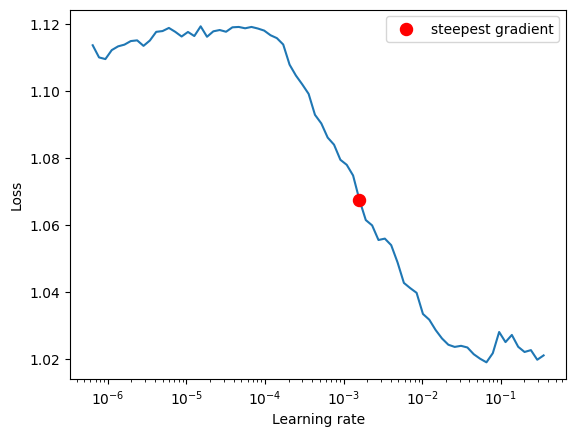

In [10]:
lr_finder.plot()  
plt.show()

# Start train

In [14]:
seq_model = Seq1Model(in_ch = len(train_dataset[0][0]), out_ch = len(train_dataset[0][1]), lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | HumanLegNet | 3.7 M  | train
1 | loss  | MSELoss     | 0      | train
----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.954    Total estimated model params size (MB)
167       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.90920 |
val_p_k562_minp_rep1: 0.03736 |val_p_k562_minp_rep2: 0.00168 |val_p_k562_minp_avg: -0.00551 |
val_p_k562_sv40p_rep1: 0.00023 |val_p_k562_sv40p_rep1: -0.07210 |val_p_k562_sv40p_avg: -0.03296 |
val_p_hepg2_minp_rep1: 0.02653 |val_p_hepg2_minp_rep2: 0.03914 |val_p_hepg2_minp_avg: -0.04686 |
val_p_hepg2_sv40p_rep1: 0.06196 |val_p_hepg2_sv40p_rep2: -0.02845 |val_p_hepg2_sv40p_avg: 0.02867 |
----------------------------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.96013 |
val_p_k562_minp_rep1: 0.22434 |val_p_k562_minp_rep2: 0.27666 |val_p_k562_minp_avg: 0.28956 |
val_p_k562_sv40p_rep1: 0.10689 |val_p_k562_sv40p_rep1: 0.10692 |val_p_k562_sv40p_avg: 0.10731 |
val_p_hepg2_minp_rep1: 0.16579 |val_p_hepg2_minp_rep2: 0.14706 |val_p_hepg2_minp_avg: 0.17329 |
val_p_hepg2_sv40p_rep1: 0.17188 |val_p_hepg2_sv40p_rep2: 0.13943 |val_p_hepg2_sv40p_avg: 0.17892 |
 train_loss: 0.93668 | train_pearson: 0.23879 | val_pearson: 0.17400 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.95036 |
val_p_k562_minp_rep1: 0.25046 |val_p_k562_minp_rep2: 0.29874 |val_p_k562_minp_avg: 0.31759 |
val_p_k562_sv40p_rep1: 0.14242 |val_p_k562_sv40p_rep1: 0.14245 |val_p_k562_sv40p_avg: 0.15983 |
val_p_hepg2_minp_rep1: 0.18865 |val_p_hepg2_minp_rep2: 0.17775 |val_p_hepg2_minp_avg: 0.20555 |
val_p_hepg2_sv40p_rep1: 0.22910 |val_p_hepg2_sv40p_rep2: 0.18402 |val_p_hepg2_sv40p_avg: 0.24047 |
 train_loss: 0.90003 | train_pearson: 0.30937 | val_pearson: 0.21142 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.95747 |
val_p_k562_minp_rep1: 0.21685 |val_p_k562_minp_rep2: 0.26611 |val_p_k562_minp_avg: 0.28074 |
val_p_k562_sv40p_rep1: 0.11505 |val_p_k562_sv40p_rep1: 0.11511 |val_p_k562_sv40p_avg: 0.12240 |
val_p_hepg2_minp_rep1: 0.18329 |val_p_hepg2_minp_rep2: 0.15852 |val_p_hepg2_minp_avg: 0.19223 |
val_p_hepg2_sv40p_rep1: 0.17704 |val_p_hepg2_sv40p_rep2: 0.16038 |val_p_hepg2_sv40p_avg: 0.19430 |
 train_loss: 0.88584 | train_pearson: 0.33164 | val_pearson: 0.18184 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.93129 |
val_p_k562_minp_rep1: 0.24940 |val_p_k562_minp_rep2: 0.30524 |val_p_k562_minp_avg: 0.31952 |
val_p_k562_sv40p_rep1: 0.14750 |val_p_k562_sv40p_rep1: 0.14752 |val_p_k562_sv40p_avg: 0.16148 |
val_p_hepg2_minp_rep1: 0.21089 |val_p_hepg2_minp_rep2: 0.19961 |val_p_hepg2_minp_avg: 0.23193 |
val_p_hepg2_sv40p_rep1: 0.21977 |val_p_hepg2_sv40p_rep2: 0.20669 |val_p_hepg2_sv40p_avg: 0.25067 |
 train_loss: 0.87897 | train_pearson: 0.34176 | val_pearson: 0.22085 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.93441 |
val_p_k562_minp_rep1: 0.24513 |val_p_k562_minp_rep2: 0.31700 |val_p_k562_minp_avg: 0.32603 |
val_p_k562_sv40p_rep1: 0.13969 |val_p_k562_sv40p_rep1: 0.13971 |val_p_k562_sv40p_avg: 0.15965 |
val_p_hepg2_minp_rep1: 0.20488 |val_p_hepg2_minp_rep2: 0.17664 |val_p_hepg2_minp_avg: 0.21826 |
val_p_hepg2_sv40p_rep1: 0.20699 |val_p_hepg2_sv40p_rep2: 0.18644 |val_p_hepg2_sv40p_avg: 0.22976 |
 train_loss: 0.87367 | train_pearson: 0.34933 | val_pearson: 0.21252 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 5.00000 | val_loss: 0.94044 |
val_p_k562_minp_rep1: 0.25179 |val_p_k562_minp_rep2: 0.31547 |val_p_k562_minp_avg: 0.32851 |
val_p_k562_sv40p_rep1: 0.14348 |val_p_k562_sv40p_rep1: 0.14348 |val_p_k562_sv40p_avg: 0.16249 |
val_p_hepg2_minp_rep1: 0.20209 |val_p_hepg2_minp_rep2: 0.18711 |val_p_hepg2_minp_avg: 0.21998 |
val_p_hepg2_sv40p_rep1: 0.20350 |val_p_hepg2_sv40p_rep2: 0.17391 |val_p_hepg2_sv40p_avg: 0.22088 |
 train_loss: 0.86786 | train_pearson: 0.35741 | val_pearson: 0.21272 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 6.00000 | val_loss: 0.94391 |
val_p_k562_minp_rep1: 0.25379 |val_p_k562_minp_rep2: 0.31552 |val_p_k562_minp_avg: 0.33025 |
val_p_k562_sv40p_rep1: 0.14430 |val_p_k562_sv40p_rep1: 0.14430 |val_p_k562_sv40p_avg: 0.16066 |
val_p_hepg2_minp_rep1: 0.21452 |val_p_hepg2_minp_rep2: 0.18268 |val_p_hepg2_minp_avg: 0.22812 |
val_p_hepg2_sv40p_rep1: 0.21813 |val_p_hepg2_sv40p_rep2: 0.18811 |val_p_hepg2_sv40p_avg: 0.23732 |
 train_loss: 0.86245 | train_pearson: 0.36497 | val_pearson: 0.21814 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 7.00000 | val_loss: 0.92989 |
val_p_k562_minp_rep1: 0.25342 |val_p_k562_minp_rep2: 0.31882 |val_p_k562_minp_avg: 0.33286 |
val_p_k562_sv40p_rep1: 0.14522 |val_p_k562_sv40p_rep1: 0.14522 |val_p_k562_sv40p_avg: 0.16648 |
val_p_hepg2_minp_rep1: 0.22517 |val_p_hepg2_minp_rep2: 0.21160 |val_p_hepg2_minp_avg: 0.24968 |
val_p_hepg2_sv40p_rep1: 0.22457 |val_p_hepg2_sv40p_rep2: 0.21468 |val_p_hepg2_sv40p_avg: 0.25769 |
 train_loss: 0.85756 | train_pearson: 0.37169 | val_pearson: 0.22878 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 8.00000 | val_loss: 0.94689 |
val_p_k562_minp_rep1: 0.25276 |val_p_k562_minp_rep2: 0.31043 |val_p_k562_minp_avg: 0.32707 |
val_p_k562_sv40p_rep1: 0.13635 |val_p_k562_sv40p_rep1: 0.13636 |val_p_k562_sv40p_avg: 0.14002 |
val_p_hepg2_minp_rep1: 0.21076 |val_p_hepg2_minp_rep2: 0.19680 |val_p_hepg2_minp_avg: 0.23524 |
val_p_hepg2_sv40p_rep1: 0.19780 |val_p_hepg2_sv40p_rep2: 0.18453 |val_p_hepg2_sv40p_avg: 0.22389 |
 train_loss: 0.85291 | train_pearson: 0.37800 | val_pearson: 0.21267 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 9.00000 | val_loss: 0.94023 |
val_p_k562_minp_rep1: 0.24318 |val_p_k562_minp_rep2: 0.32348 |val_p_k562_minp_avg: 0.33078 |
val_p_k562_sv40p_rep1: 0.15294 |val_p_k562_sv40p_rep1: 0.15292 |val_p_k562_sv40p_avg: 0.16557 |
val_p_hepg2_minp_rep1: 0.22120 |val_p_hepg2_minp_rep2: 0.18386 |val_p_hepg2_minp_avg: 0.23731 |
val_p_hepg2_sv40p_rep1: 0.20913 |val_p_hepg2_sv40p_rep2: 0.20353 |val_p_hepg2_sv40p_avg: 0.24218 |
 train_loss: 0.84755 | train_pearson: 0.38471 | val_pearson: 0.22217 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 10.00000 | val_loss: 0.94778 |
val_p_k562_minp_rep1: 0.23834 |val_p_k562_minp_rep2: 0.31012 |val_p_k562_minp_avg: 0.32212 |
val_p_k562_sv40p_rep1: 0.13766 |val_p_k562_sv40p_rep1: 0.13766 |val_p_k562_sv40p_avg: 0.13372 |
val_p_hepg2_minp_rep1: 0.20510 |val_p_hepg2_minp_rep2: 0.15716 |val_p_hepg2_minp_avg: 0.21224 |
val_p_hepg2_sv40p_rep1: 0.16397 |val_p_hepg2_sv40p_rep2: 0.16350 |val_p_hepg2_sv40p_avg: 0.18663 |
 train_loss: 0.84316 | train_pearson: 0.39051 | val_pearson: 0.19735 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 11.00000 | val_loss: 0.92989 |
val_p_k562_minp_rep1: 0.24241 |val_p_k562_minp_rep2: 0.30666 |val_p_k562_minp_avg: 0.31932 |
val_p_k562_sv40p_rep1: 0.15032 |val_p_k562_sv40p_rep1: 0.15032 |val_p_k562_sv40p_avg: 0.16307 |
val_p_hepg2_minp_rep1: 0.22174 |val_p_hepg2_minp_rep2: 0.21050 |val_p_hepg2_minp_avg: 0.24959 |
val_p_hepg2_sv40p_rep1: 0.24596 |val_p_hepg2_sv40p_rep2: 0.23095 |val_p_hepg2_sv40p_avg: 0.28079 |
 train_loss: 0.83861 | train_pearson: 0.39632 | val_pearson: 0.23097 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 12.00000 | val_loss: 0.92918 |
val_p_k562_minp_rep1: 0.24084 |val_p_k562_minp_rep2: 0.32376 |val_p_k562_minp_avg: 0.33306 |
val_p_k562_sv40p_rep1: 0.14984 |val_p_k562_sv40p_rep1: 0.14984 |val_p_k562_sv40p_avg: 0.15939 |
val_p_hepg2_minp_rep1: 0.21667 |val_p_hepg2_minp_rep2: 0.21312 |val_p_hepg2_minp_avg: 0.24895 |
val_p_hepg2_sv40p_rep1: 0.22374 |val_p_hepg2_sv40p_rep2: 0.22018 |val_p_hepg2_sv40p_avg: 0.26051 |
 train_loss: 0.83364 | train_pearson: 0.40249 | val_pearson: 0.22832 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 13.00000 | val_loss: 0.93970 |
val_p_k562_minp_rep1: 0.25609 |val_p_k562_minp_rep2: 0.31422 |val_p_k562_minp_avg: 0.33414 |
val_p_k562_sv40p_rep1: 0.14293 |val_p_k562_sv40p_rep1: 0.14293 |val_p_k562_sv40p_avg: 0.14049 |
val_p_hepg2_minp_rep1: 0.22085 |val_p_hepg2_minp_rep2: 0.18566 |val_p_hepg2_minp_avg: 0.23544 |
val_p_hepg2_sv40p_rep1: 0.18413 |val_p_hepg2_sv40p_rep2: 0.18890 |val_p_hepg2_sv40p_avg: 0.21828 |
 train_loss: 0.82898 | train_pearson: 0.40795 | val_pearson: 0.21367 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 14.00000 | val_loss: 0.94596 |
val_p_k562_minp_rep1: 0.24737 |val_p_k562_minp_rep2: 0.31705 |val_p_k562_minp_avg: 0.33327 |
val_p_k562_sv40p_rep1: 0.15664 |val_p_k562_sv40p_rep1: 0.15664 |val_p_k562_sv40p_avg: 0.15613 |
val_p_hepg2_minp_rep1: 0.21770 |val_p_hepg2_minp_rep2: 0.18657 |val_p_hepg2_minp_avg: 0.24250 |
val_p_hepg2_sv40p_rep1: 0.18028 |val_p_hepg2_sv40p_rep2: 0.19283 |val_p_hepg2_sv40p_avg: 0.21889 |
 train_loss: 0.82340 | train_pearson: 0.41505 | val_pearson: 0.21716 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 15.00000 | val_loss: 0.95380 |
val_p_k562_minp_rep1: 0.22684 |val_p_k562_minp_rep2: 0.31600 |val_p_k562_minp_avg: 0.32150 |
val_p_k562_sv40p_rep1: 0.12794 |val_p_k562_sv40p_rep1: 0.12794 |val_p_k562_sv40p_avg: 0.13179 |
val_p_hepg2_minp_rep1: 0.21258 |val_p_hepg2_minp_rep2: 0.18492 |val_p_hepg2_minp_avg: 0.23056 |
val_p_hepg2_sv40p_rep1: 0.21240 |val_p_hepg2_sv40p_rep2: 0.20660 |val_p_hepg2_sv40p_avg: 0.24639 |
 train_loss: 0.81825 | train_pearson: 0.42084 | val_pearson: 0.21212 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 16.00000 | val_loss: 0.94476 |
val_p_k562_minp_rep1: 0.24189 |val_p_k562_minp_rep2: 0.32817 |val_p_k562_minp_avg: 0.33721 |
val_p_k562_sv40p_rep1: 0.14663 |val_p_k562_sv40p_rep1: 0.14663 |val_p_k562_sv40p_avg: 0.15628 |
val_p_hepg2_minp_rep1: 0.21551 |val_p_hepg2_minp_rep2: 0.20336 |val_p_hepg2_minp_avg: 0.24360 |
val_p_hepg2_sv40p_rep1: 0.21986 |val_p_hepg2_sv40p_rep2: 0.20312 |val_p_hepg2_sv40p_avg: 0.24792 |
 train_loss: 0.81290 | train_pearson: 0.42719 | val_pearson: 0.22418 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 17.00000 | val_loss: 0.93894 |
val_p_k562_minp_rep1: 0.25424 |val_p_k562_minp_rep2: 0.32509 |val_p_k562_minp_avg: 0.34266 |
val_p_k562_sv40p_rep1: 0.15458 |val_p_k562_sv40p_rep1: 0.15458 |val_p_k562_sv40p_avg: 0.15599 |
val_p_hepg2_minp_rep1: 0.22390 |val_p_hepg2_minp_rep2: 0.19701 |val_p_hepg2_minp_avg: 0.24361 |
val_p_hepg2_sv40p_rep1: 0.22371 |val_p_hepg2_sv40p_rep2: 0.21022 |val_p_hepg2_sv40p_avg: 0.25428 |
 train_loss: 0.80731 | train_pearson: 0.43335 | val_pearson: 0.22832 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 18.00000 | val_loss: 0.94369 |
val_p_k562_minp_rep1: 0.23387 |val_p_k562_minp_rep2: 0.31441 |val_p_k562_minp_avg: 0.32204 |
val_p_k562_sv40p_rep1: 0.14196 |val_p_k562_sv40p_rep1: 0.14196 |val_p_k562_sv40p_avg: 0.14996 |
val_p_hepg2_minp_rep1: 0.21137 |val_p_hepg2_minp_rep2: 0.20926 |val_p_hepg2_minp_avg: 0.24491 |
val_p_hepg2_sv40p_rep1: 0.21935 |val_p_hepg2_sv40p_rep2: 0.20906 |val_p_hepg2_sv40p_avg: 0.25413 |
 train_loss: 0.80255 | train_pearson: 0.43888 | val_pearson: 0.22103 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 19.00000 | val_loss: 0.94117 |
val_p_k562_minp_rep1: 0.24603 |val_p_k562_minp_rep2: 0.32427 |val_p_k562_minp_avg: 0.33778 |
val_p_k562_sv40p_rep1: 0.15122 |val_p_k562_sv40p_rep1: 0.15122 |val_p_k562_sv40p_avg: 0.15371 |
val_p_hepg2_minp_rep1: 0.21409 |val_p_hepg2_minp_rep2: 0.19409 |val_p_hepg2_minp_avg: 0.23976 |
val_p_hepg2_sv40p_rep1: 0.19698 |val_p_hepg2_sv40p_rep2: 0.19911 |val_p_hepg2_sv40p_avg: 0.23135 |
 train_loss: 0.79716 | train_pearson: 0.44494 | val_pearson: 0.21997 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 20.00000 | val_loss: 0.94112 |
val_p_k562_minp_rep1: 0.25437 |val_p_k562_minp_rep2: 0.31489 |val_p_k562_minp_avg: 0.33712 |
val_p_k562_sv40p_rep1: 0.13446 |val_p_k562_sv40p_rep1: 0.13446 |val_p_k562_sv40p_avg: 0.13702 |
val_p_hepg2_minp_rep1: 0.22857 |val_p_hepg2_minp_rep2: 0.17908 |val_p_hepg2_minp_avg: 0.24010 |
val_p_hepg2_sv40p_rep1: 0.17904 |val_p_hepg2_sv40p_rep2: 0.18204 |val_p_hepg2_sv40p_avg: 0.21139 |
 train_loss: 0.79216 | train_pearson: 0.45075 | val_pearson: 0.21105 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 21.00000 | val_loss: 0.95221 |
val_p_k562_minp_rep1: 0.24350 |val_p_k562_minp_rep2: 0.31789 |val_p_k562_minp_avg: 0.33127 |
val_p_k562_sv40p_rep1: 0.14333 |val_p_k562_sv40p_rep1: 0.14333 |val_p_k562_sv40p_avg: 0.14605 |
val_p_hepg2_minp_rep1: 0.21098 |val_p_hepg2_minp_rep2: 0.19277 |val_p_hepg2_minp_avg: 0.23450 |
val_p_hepg2_sv40p_rep1: 0.19543 |val_p_hepg2_sv40p_rep2: 0.19915 |val_p_hepg2_sv40p_avg: 0.23222 |
 train_loss: 0.78640 | train_pearson: 0.45689 | val_pearson: 0.21587 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 22.00000 | val_loss: 0.94280 |
val_p_k562_minp_rep1: 0.24085 |val_p_k562_minp_rep2: 0.32013 |val_p_k562_minp_avg: 0.32968 |
val_p_k562_sv40p_rep1: 0.14631 |val_p_k562_sv40p_rep1: 0.14631 |val_p_k562_sv40p_avg: 0.15514 |
val_p_hepg2_minp_rep1: 0.21311 |val_p_hepg2_minp_rep2: 0.18945 |val_p_hepg2_minp_avg: 0.23750 |
val_p_hepg2_sv40p_rep1: 0.18734 |val_p_hepg2_sv40p_rep2: 0.19070 |val_p_hepg2_sv40p_avg: 0.22122 |
 train_loss: 0.78124 | train_pearson: 0.46269 | val_pearson: 0.21481 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 23.00000 | val_loss: 0.94721 |
val_p_k562_minp_rep1: 0.22354 |val_p_k562_minp_rep2: 0.30414 |val_p_k562_minp_avg: 0.31069 |
val_p_k562_sv40p_rep1: 0.14393 |val_p_k562_sv40p_rep1: 0.14393 |val_p_k562_sv40p_avg: 0.15668 |
val_p_hepg2_minp_rep1: 0.19992 |val_p_hepg2_minp_rep2: 0.21319 |val_p_hepg2_minp_avg: 0.24435 |
val_p_hepg2_sv40p_rep1: 0.20339 |val_p_hepg2_sv40p_rep2: 0.20949 |val_p_hepg2_sv40p_avg: 0.24472 |
 train_loss: 0.77465 | train_pearson: 0.46993 | val_pearson: 0.21650 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 24.00000 | val_loss: 0.94479 |
val_p_k562_minp_rep1: 0.22836 |val_p_k562_minp_rep2: 0.30754 |val_p_k562_minp_avg: 0.31465 |
val_p_k562_sv40p_rep1: 0.13106 |val_p_k562_sv40p_rep1: 0.13106 |val_p_k562_sv40p_avg: 0.14044 |
val_p_hepg2_minp_rep1: 0.21330 |val_p_hepg2_minp_rep2: 0.19461 |val_p_hepg2_minp_avg: 0.23906 |
val_p_hepg2_sv40p_rep1: 0.18375 |val_p_hepg2_sv40p_rep2: 0.18557 |val_p_hepg2_sv40p_avg: 0.21816 |
 train_loss: 0.76730 | train_pearson: 0.47771 | val_pearson: 0.20730 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 25.00000 | val_loss: 0.96321 |
val_p_k562_minp_rep1: 0.24610 |val_p_k562_minp_rep2: 0.30960 |val_p_k562_minp_avg: 0.32495 |
val_p_k562_sv40p_rep1: 0.11546 |val_p_k562_sv40p_rep1: 0.11545 |val_p_k562_sv40p_avg: 0.12000 |
val_p_hepg2_minp_rep1: 0.20917 |val_p_hepg2_minp_rep2: 0.18655 |val_p_hepg2_minp_avg: 0.23134 |
val_p_hepg2_sv40p_rep1: 0.18376 |val_p_hepg2_sv40p_rep2: 0.18057 |val_p_hepg2_sv40p_avg: 0.21403 |
 train_loss: 0.75969 | train_pearson: 0.48591 | val_pearson: 0.20308 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 26.00000 | val_loss: 0.97542 |
val_p_k562_minp_rep1: 0.21763 |val_p_k562_minp_rep2: 0.28617 |val_p_k562_minp_avg: 0.29463 |
val_p_k562_sv40p_rep1: 0.11926 |val_p_k562_sv40p_rep1: 0.11925 |val_p_k562_sv40p_avg: 0.13441 |
val_p_hepg2_minp_rep1: 0.19625 |val_p_hepg2_minp_rep2: 0.18926 |val_p_hepg2_minp_avg: 0.22374 |
val_p_hepg2_sv40p_rep1: 0.19965 |val_p_hepg2_sv40p_rep2: 0.18790 |val_p_hepg2_sv40p_avg: 0.22809 |
 train_loss: 0.75113 | train_pearson: 0.49482 | val_pearson: 0.19969 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 27.00000 | val_loss: 0.97431 |
val_p_k562_minp_rep1: 0.21507 |val_p_k562_minp_rep2: 0.29716 |val_p_k562_minp_avg: 0.30067 |
val_p_k562_sv40p_rep1: 0.11908 |val_p_k562_sv40p_rep1: 0.11908 |val_p_k562_sv40p_avg: 0.13374 |
val_p_hepg2_minp_rep1: 0.19573 |val_p_hepg2_minp_rep2: 0.17174 |val_p_hepg2_minp_avg: 0.21336 |
val_p_hepg2_sv40p_rep1: 0.17430 |val_p_hepg2_sv40p_rep2: 0.16247 |val_p_hepg2_sv40p_avg: 0.19674 |
 train_loss: 0.74082 | train_pearson: 0.50531 | val_pearson: 0.19159 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 28.00000 | val_loss: 0.97606 |
val_p_k562_minp_rep1: 0.20082 |val_p_k562_minp_rep2: 0.29521 |val_p_k562_minp_avg: 0.29165 |
val_p_k562_sv40p_rep1: 0.11481 |val_p_k562_sv40p_rep1: 0.11481 |val_p_k562_sv40p_avg: 0.13086 |
val_p_hepg2_minp_rep1: 0.19011 |val_p_hepg2_minp_rep2: 0.18289 |val_p_hepg2_minp_avg: 0.21580 |
val_p_hepg2_sv40p_rep1: 0.19478 |val_p_hepg2_sv40p_rep2: 0.17343 |val_p_hepg2_sv40p_avg: 0.21791 |
 train_loss: 0.72965 | train_pearson: 0.51668 | val_pearson: 0.19359 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 29.00000 | val_loss: 0.98229 |
val_p_k562_minp_rep1: 0.19746 |val_p_k562_minp_rep2: 0.28742 |val_p_k562_minp_avg: 0.28462 |
val_p_k562_sv40p_rep1: 0.10636 |val_p_k562_sv40p_rep1: 0.10636 |val_p_k562_sv40p_avg: 0.13211 |
val_p_hepg2_minp_rep1: 0.18041 |val_p_hepg2_minp_rep2: 0.17815 |val_p_hepg2_minp_avg: 0.20943 |
val_p_hepg2_sv40p_rep1: 0.19170 |val_p_hepg2_sv40p_rep2: 0.17665 |val_p_hepg2_sv40p_avg: 0.21630 |
 train_loss: 0.71768 | train_pearson: 0.52827 | val_pearson: 0.18892 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 30.00000 | val_loss: 0.98814 |
val_p_k562_minp_rep1: 0.20529 |val_p_k562_minp_rep2: 0.28548 |val_p_k562_minp_avg: 0.28824 |
val_p_k562_sv40p_rep1: 0.10769 |val_p_k562_sv40p_rep1: 0.10769 |val_p_k562_sv40p_avg: 0.12986 |
val_p_hepg2_minp_rep1: 0.18198 |val_p_hepg2_minp_rep2: 0.17488 |val_p_hepg2_minp_avg: 0.20596 |
val_p_hepg2_sv40p_rep1: 0.19752 |val_p_hepg2_sv40p_rep2: 0.17970 |val_p_hepg2_sv40p_avg: 0.22323 |
 train_loss: 0.70394 | train_pearson: 0.54161 | val_pearson: 0.19063 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 31.00000 | val_loss: 1.04499 |
val_p_k562_minp_rep1: 0.18965 |val_p_k562_minp_rep2: 0.26925 |val_p_k562_minp_avg: 0.26958 |
val_p_k562_sv40p_rep1: 0.08722 |val_p_k562_sv40p_rep1: 0.08722 |val_p_k562_sv40p_avg: 0.09892 |
val_p_hepg2_minp_rep1: 0.16672 |val_p_hepg2_minp_rep2: 0.13298 |val_p_hepg2_minp_avg: 0.17615 |
val_p_hepg2_sv40p_rep1: 0.13882 |val_p_hepg2_sv40p_rep2: 0.13376 |val_p_hepg2_sv40p_avg: 0.15871 |
 train_loss: 0.68979 | train_pearson: 0.55489 | val_pearson: 0.15908 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 32.00000 | val_loss: 1.00983 |
val_p_k562_minp_rep1: 0.18787 |val_p_k562_minp_rep2: 0.28957 |val_p_k562_minp_avg: 0.27882 |
val_p_k562_sv40p_rep1: 0.10551 |val_p_k562_sv40p_rep1: 0.10550 |val_p_k562_sv40p_avg: 0.12894 |
val_p_hepg2_minp_rep1: 0.17606 |val_p_hepg2_minp_rep2: 0.17474 |val_p_hepg2_minp_avg: 0.20627 |
val_p_hepg2_sv40p_rep1: 0.18611 |val_p_hepg2_sv40p_rep2: 0.17752 |val_p_hepg2_sv40p_avg: 0.21526 |
 train_loss: 0.67319 | train_pearson: 0.56996 | val_pearson: 0.18601 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 33.00000 | val_loss: 1.01978 |
val_p_k562_minp_rep1: 0.19487 |val_p_k562_minp_rep2: 0.28358 |val_p_k562_minp_avg: 0.27987 |
val_p_k562_sv40p_rep1: 0.10110 |val_p_k562_sv40p_rep1: 0.10110 |val_p_k562_sv40p_avg: 0.12361 |
val_p_hepg2_minp_rep1: 0.17338 |val_p_hepg2_minp_rep2: 0.17336 |val_p_hepg2_minp_avg: 0.20553 |
val_p_hepg2_sv40p_rep1: 0.17884 |val_p_hepg2_sv40p_rep2: 0.17120 |val_p_hepg2_sv40p_avg: 0.20632 |
 train_loss: 0.65639 | train_pearson: 0.58482 | val_pearson: 0.18273 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 34.00000 | val_loss: 1.04444 |
val_p_k562_minp_rep1: 0.19329 |val_p_k562_minp_rep2: 0.27040 |val_p_k562_minp_avg: 0.27102 |
val_p_k562_sv40p_rep1: 0.08469 |val_p_k562_sv40p_rep1: 0.08470 |val_p_k562_sv40p_avg: 0.09666 |
val_p_hepg2_minp_rep1: 0.17061 |val_p_hepg2_minp_rep2: 0.15916 |val_p_hepg2_minp_avg: 0.18868 |
val_p_hepg2_sv40p_rep1: 0.16457 |val_p_hepg2_sv40p_rep2: 0.15475 |val_p_hepg2_sv40p_avg: 0.18803 |
 train_loss: 0.63883 | train_pearson: 0.59970 | val_pearson: 0.16888 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 35.00000 | val_loss: 1.04221 |
val_p_k562_minp_rep1: 0.19668 |val_p_k562_minp_rep2: 0.28331 |val_p_k562_minp_avg: 0.28128 |
val_p_k562_sv40p_rep1: 0.08212 |val_p_k562_sv40p_rep1: 0.08212 |val_p_k562_sv40p_avg: 0.09886 |
val_p_hepg2_minp_rep1: 0.16865 |val_p_hepg2_minp_rep2: 0.17122 |val_p_hepg2_minp_avg: 0.19586 |
val_p_hepg2_sv40p_rep1: 0.18208 |val_p_hepg2_sv40p_rep2: 0.16524 |val_p_hepg2_sv40p_avg: 0.20542 |
 train_loss: 0.62017 | train_pearson: 0.61523 | val_pearson: 0.17607 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 36.00000 | val_loss: 1.06347 |
val_p_k562_minp_rep1: 0.18558 |val_p_k562_minp_rep2: 0.26649 |val_p_k562_minp_avg: 0.26491 |
val_p_k562_sv40p_rep1: 0.07543 |val_p_k562_sv40p_rep1: 0.07542 |val_p_k562_sv40p_avg: 0.08999 |
val_p_hepg2_minp_rep1: 0.16549 |val_p_hepg2_minp_rep2: 0.16343 |val_p_hepg2_minp_avg: 0.19027 |
val_p_hepg2_sv40p_rep1: 0.16999 |val_p_hepg2_sv40p_rep2: 0.16820 |val_p_hepg2_sv40p_avg: 0.19997 |
 train_loss: 0.59988 | train_pearson: 0.63154 | val_pearson: 0.16793 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 37.00000 | val_loss: 1.07436 |
val_p_k562_minp_rep1: 0.17208 |val_p_k562_minp_rep2: 0.26694 |val_p_k562_minp_avg: 0.25627 |
val_p_k562_sv40p_rep1: 0.08074 |val_p_k562_sv40p_rep1: 0.08074 |val_p_k562_sv40p_avg: 0.10313 |
val_p_hepg2_minp_rep1: 0.15517 |val_p_hepg2_minp_rep2: 0.17274 |val_p_hepg2_minp_avg: 0.19151 |
val_p_hepg2_sv40p_rep1: 0.17033 |val_p_hepg2_sv40p_rep2: 0.16827 |val_p_hepg2_sv40p_avg: 0.20154 |
 train_loss: 0.57996 | train_pearson: 0.64704 | val_pearson: 0.16829 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 38.00000 | val_loss: 1.09272 |
val_p_k562_minp_rep1: 0.17063 |val_p_k562_minp_rep2: 0.25419 |val_p_k562_minp_avg: 0.24938 |
val_p_k562_sv40p_rep1: 0.07422 |val_p_k562_sv40p_rep1: 0.07422 |val_p_k562_sv40p_avg: 0.09730 |
val_p_hepg2_minp_rep1: 0.15318 |val_p_hepg2_minp_rep2: 0.16232 |val_p_hepg2_minp_avg: 0.18250 |
val_p_hepg2_sv40p_rep1: 0.16465 |val_p_hepg2_sv40p_rep2: 0.15556 |val_p_hepg2_sv40p_avg: 0.19010 |
 train_loss: 0.55980 | train_pearson: 0.66224 | val_pearson: 0.16069 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 39.00000 | val_loss: 1.10626 |
val_p_k562_minp_rep1: 0.17020 |val_p_k562_minp_rep2: 0.25130 |val_p_k562_minp_avg: 0.24714 |
val_p_k562_sv40p_rep1: 0.06729 |val_p_k562_sv40p_rep1: 0.06729 |val_p_k562_sv40p_avg: 0.08570 |
val_p_hepg2_minp_rep1: 0.15408 |val_p_hepg2_minp_rep2: 0.16162 |val_p_hepg2_minp_avg: 0.18242 |
val_p_hepg2_sv40p_rep1: 0.16240 |val_p_hepg2_sv40p_rep2: 0.15032 |val_p_hepg2_sv40p_avg: 0.18455 |
 train_loss: 0.53899 | train_pearson: 0.67760 | val_pearson: 0.15703 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 40.00000 | val_loss: 1.11557 |
val_p_k562_minp_rep1: 0.15807 |val_p_k562_minp_rep2: 0.24638 |val_p_k562_minp_avg: 0.23654 |
val_p_k562_sv40p_rep1: 0.06118 |val_p_k562_sv40p_rep1: 0.06118 |val_p_k562_sv40p_avg: 0.08251 |
val_p_hepg2_minp_rep1: 0.13715 |val_p_hepg2_minp_rep2: 0.15749 |val_p_hepg2_minp_avg: 0.16968 |
val_p_hepg2_sv40p_rep1: 0.16275 |val_p_hepg2_sv40p_rep2: 0.15106 |val_p_hepg2_sv40p_avg: 0.18625 |
 train_loss: 0.52013 | train_pearson: 0.69122 | val_pearson: 0.15085 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 41.00000 | val_loss: 1.13531 |
val_p_k562_minp_rep1: 0.15978 |val_p_k562_minp_rep2: 0.23620 |val_p_k562_minp_avg: 0.23172 |
val_p_k562_sv40p_rep1: 0.05763 |val_p_k562_sv40p_rep1: 0.05763 |val_p_k562_sv40p_avg: 0.07879 |
val_p_hepg2_minp_rep1: 0.13297 |val_p_hepg2_minp_rep2: 0.14742 |val_p_hepg2_minp_avg: 0.16065 |
val_p_hepg2_sv40p_rep1: 0.15681 |val_p_hepg2_sv40p_rep2: 0.14026 |val_p_hepg2_sv40p_avg: 0.17547 |
 train_loss: 0.50159 | train_pearson: 0.70430 | val_pearson: 0.14461 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 42.00000 | val_loss: 1.15331 |
val_p_k562_minp_rep1: 0.15537 |val_p_k562_minp_rep2: 0.23694 |val_p_k562_minp_avg: 0.22942 |
val_p_k562_sv40p_rep1: 0.05850 |val_p_k562_sv40p_rep1: 0.05850 |val_p_k562_sv40p_avg: 0.07769 |
val_p_hepg2_minp_rep1: 0.13513 |val_p_hepg2_minp_rep2: 0.14687 |val_p_hepg2_minp_avg: 0.16085 |
val_p_hepg2_sv40p_rep1: 0.14769 |val_p_hepg2_sv40p_rep2: 0.13605 |val_p_hepg2_sv40p_avg: 0.16748 |
 train_loss: 0.48412 | train_pearson: 0.71638 | val_pearson: 0.14254 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 43.00000 | val_loss: 1.16544 |
val_p_k562_minp_rep1: 0.15511 |val_p_k562_minp_rep2: 0.23908 |val_p_k562_minp_avg: 0.23116 |
val_p_k562_sv40p_rep1: 0.06207 |val_p_k562_sv40p_rep1: 0.06207 |val_p_k562_sv40p_avg: 0.08049 |
val_p_hepg2_minp_rep1: 0.13461 |val_p_hepg2_minp_rep2: 0.14605 |val_p_hepg2_minp_avg: 0.16090 |
val_p_hepg2_sv40p_rep1: 0.15056 |val_p_hepg2_sv40p_rep2: 0.13506 |val_p_hepg2_sv40p_avg: 0.16929 |
 train_loss: 0.46866 | train_pearson: 0.72695 | val_pearson: 0.14387 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 44.00000 | val_loss: 1.17097 |
val_p_k562_minp_rep1: 0.15331 |val_p_k562_minp_rep2: 0.23563 |val_p_k562_minp_avg: 0.22823 |
val_p_k562_sv40p_rep1: 0.05409 |val_p_k562_sv40p_rep1: 0.05409 |val_p_k562_sv40p_avg: 0.07489 |
val_p_hepg2_minp_rep1: 0.13337 |val_p_hepg2_minp_rep2: 0.14532 |val_p_hepg2_minp_avg: 0.15871 |
val_p_hepg2_sv40p_rep1: 0.14904 |val_p_hepg2_sv40p_rep2: 0.13215 |val_p_hepg2_sv40p_avg: 0.16591 |
 train_loss: 0.45547 | train_pearson: 0.73582 | val_pearson: 0.14040 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 45.00000 | val_loss: 1.18897 |
val_p_k562_minp_rep1: 0.15292 |val_p_k562_minp_rep2: 0.23313 |val_p_k562_minp_avg: 0.22636 |
val_p_k562_sv40p_rep1: 0.05311 |val_p_k562_sv40p_rep1: 0.05311 |val_p_k562_sv40p_avg: 0.07238 |
val_p_hepg2_minp_rep1: 0.13123 |val_p_hepg2_minp_rep2: 0.14024 |val_p_hepg2_minp_avg: 0.15514 |
val_p_hepg2_sv40p_rep1: 0.14403 |val_p_hepg2_sv40p_rep2: 0.13346 |val_p_hepg2_sv40p_avg: 0.16398 |
 train_loss: 0.44404 | train_pearson: 0.74339 | val_pearson: 0.13826 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 46.00000 | val_loss: 1.19685 |
val_p_k562_minp_rep1: 0.15272 |val_p_k562_minp_rep2: 0.23251 |val_p_k562_minp_avg: 0.22597 |
val_p_k562_sv40p_rep1: 0.05254 |val_p_k562_sv40p_rep1: 0.05254 |val_p_k562_sv40p_avg: 0.07285 |
val_p_hepg2_minp_rep1: 0.12704 |val_p_hepg2_minp_rep2: 0.13847 |val_p_hepg2_minp_avg: 0.15126 |
val_p_hepg2_sv40p_rep1: 0.14340 |val_p_hepg2_sv40p_rep2: 0.13013 |val_p_hepg2_sv40p_avg: 0.16161 |
 train_loss: 0.43552 | train_pearson: 0.74902 | val_pearson: 0.13675 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 47.00000 | val_loss: 1.20185 |
val_p_k562_minp_rep1: 0.14923 |val_p_k562_minp_rep2: 0.22997 |val_p_k562_minp_avg: 0.22244 |
val_p_k562_sv40p_rep1: 0.05170 |val_p_k562_sv40p_rep1: 0.05170 |val_p_k562_sv40p_avg: 0.07171 |
val_p_hepg2_minp_rep1: 0.12527 |val_p_hepg2_minp_rep2: 0.13836 |val_p_hepg2_minp_avg: 0.14989 |
val_p_hepg2_sv40p_rep1: 0.14278 |val_p_hepg2_sv40p_rep2: 0.12984 |val_p_hepg2_sv40p_avg: 0.16097 |
 train_loss: 0.42999 | train_pearson: 0.75265 | val_pearson: 0.13532 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 48.00000 | val_loss: 1.20594 |
val_p_k562_minp_rep1: 0.14972 |val_p_k562_minp_rep2: 0.23010 |val_p_k562_minp_avg: 0.22279 |
val_p_k562_sv40p_rep1: 0.05144 |val_p_k562_sv40p_rep1: 0.05144 |val_p_k562_sv40p_avg: 0.07127 |
val_p_hepg2_minp_rep1: 0.12653 |val_p_hepg2_minp_rep2: 0.13754 |val_p_hepg2_minp_avg: 0.15027 |
val_p_hepg2_sv40p_rep1: 0.14320 |val_p_hepg2_sv40p_rep2: 0.13020 |val_p_hepg2_sv40p_avg: 0.16138 |
 train_loss: 0.42645 | train_pearson: 0.75498 | val_pearson: 0.13549 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| current_epoch: 49.00000 | val_loss: 1.20645 |
val_p_k562_minp_rep1: 0.14965 |val_p_k562_minp_rep2: 0.22915 |val_p_k562_minp_avg: 0.22221 |
val_p_k562_sv40p_rep1: 0.05056 |val_p_k562_sv40p_rep1: 0.05056 |val_p_k562_sv40p_avg: 0.07060 |
val_p_hepg2_minp_rep1: 0.12555 |val_p_hepg2_minp_rep2: 0.13774 |val_p_hepg2_minp_avg: 0.14970 |
val_p_hepg2_sv40p_rep1: 0.14346 |val_p_hepg2_sv40p_rep2: 0.13002 |val_p_hepg2_sv40p_avg: 0.16144 |
 train_loss: 0.42485 | train_pearson: 0.75601 | val_pearson: 0.13505 |
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            test_loss            │        1.206375241279602        │
│  val_pearson_0_k562_minp_rep1   │       0.14998804032802582       │
│ val_pearson_10_hepg2_sv40p_rep2 │       0.13066868484020233       │
│ val_pearson_11_hepg2_sv40p_avg  │       0.16216526925563812       │
│  val_pearson_1_k562_minp_rep2   │       0.22899484634399414       │
│   val_pearson_2_k562_minp_avg   │       0.22239884734153748       │
│  val_pearson_3_k562_sv40p_rep1  │       0.05101322755217552       │
│  val_pearson_4_k562_sv40p_rep1  │       0.05101366713643074       │
│  val_pearson_5_k562_sv40p_avg   │       0.0713077038526535        │
│  val_pearson_6_hepg2_minp_rep1  │       0.12674365937709808       │
│  val_pearson_7_hepg2_minp_rep2  │       0.1385812610387802        │
│  val_pearson_8_hepg2_minp_avg   │       0.15105892717838287       │
│ val_pearson_9_hepg2_sv40p_rep1  │       0.14421716332435608       │
└─────────────────────────────────┴─────────────────────────────────┘

[{'test_loss': 1.206375241279602,
  'val_pearson_0_k562_minp_rep1': 0.14998804032802582,
  'val_pearson_1_k562_minp_rep2': 0.22899484634399414,
  'val_pearson_2_k562_minp_avg': 0.22239884734153748,
  'val_pearson_3_k562_sv40p_rep1': 0.05101322755217552,
  'val_pearson_4_k562_sv40p_rep1': 0.05101366713643074,
  'val_pearson_5_k562_sv40p_avg': 0.0713077038526535,
  'val_pearson_6_hepg2_minp_rep1': 0.12674365937709808,
  'val_pearson_7_hepg2_minp_rep2': 0.1385812610387802,
  'val_pearson_8_hepg2_minp_avg': 0.15105892717838287,
  'val_pearson_9_hepg2_sv40p_rep1': 0.14421716332435608,
  'val_pearson_10_hepg2_sv40p_rep2': 0.13066868484020233,
  'val_pearson_11_hepg2_sv40p_avg': 0.16216526925563812}]